# 02 - Label Analysis
Processing the `labels.json` exported from Label Studio. We examine the number of annotations, their distribution by type (Normal, Pennant, Wedge), and the duration of these patterns.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import numpy as np

# Paths
DATA_DIR = "../data" if os.path.exists("../data") else "/app/data"
print(f"Data directory: {DATA_DIR}")

# Find all labels.json files
label_files = glob.glob(os.path.join(DATA_DIR, "**", "*.json"), recursive=True)
print(f"Label files found: {len(label_files)}")

all_data = []
for lf in label_files:
    try:
        with open(lf, 'r') as f:
            tasks = json.load(f)
            print(f" - {os.path.relpath(lf, DATA_DIR)}: {len(tasks)} tasks")
            all_data.extend(tasks)
    except Exception as e:
        print(f"Error reading {lf}: {e}")

print(f"Total of {len(all_data)} annotated tasks.")

Data directory: ../data
Label files found: 6
 - AY1PC8\AY1PC8.json: 2 tasks
 - GFTYRV\GFTYRV.json: 27 tasks
 - J2QIYD\J2QIYD.json: 60 tasks
 - LMIRPG\LMIRPG.json: 2 tasks
 - XOBJYX\XOBJYX.json: 3 tasks
 - YH6M5S\YH6M5S.json: 1 tasks
Total of 95 annotated tasks.


In [2]:
def parse_annotation_time(time_val):
    """
    Safely parses a single JSON time value.
    """
    if time_val is None:
        return None
    try:
        numeric_ts = float(time_val)
        if numeric_ts > 3e10: 
            return pd.to_datetime(numeric_ts, unit='ms')
        else:
            return pd.to_datetime(numeric_ts, unit='s')
    except (ValueError, TypeError):
        return pd.to_datetime(time_val)

stats = []

for task in all_data:
    filename = task.get('file_upload', 'Unknown')
    
    for ann in task.get('annotations', []):
        for res in ann.get('result', []):
            val = res.get('value', {})
            labels = val.get('timeserieslabels', [])
            
            if labels:
                label_name = labels[0]
                
                # --- IMPROVED PART ---
                start = parse_annotation_time(val.get('start'))
                end = parse_annotation_time(val.get('end'))
                # ---------------------
                
                if start is None or end is None:
                    continue
                
                # Calculate duration
                duration_mins = (end - start).total_seconds() / 60
                
                # Assuming data is 5-minute intervals
                candle_count = int(duration_mins / 5)
                if candle_count < 1: candle_count = 1
                
                stats.append({
                    'File': filename,
                    'Label': label_name,
                    'Candle_Count': candle_count,
                    'Duration_Min': duration_mins
                })

df_stats = pd.DataFrame(stats)
print(f"Total annotations (Labels): {len(df_stats)}")
df_stats.head()

Total annotations (Labels): 358


,File,Label,Candle_Count,Duration_Min
0,351f4d2a-EURUSD_1H_005.csv,Bearish Normal,216,1080.0
1,351f4d2a-EURUSD_1H_005.csv,Bearish Normal,1,0.0
2,351f4d2a-EURUSD_1H_005.csv,Bullish Normal,240,1200.0
3,351f4d2a-EURUSD_1H_005.csv,Bullish Normal,180,900.0
4,7175fb3f-EURUSD_1min_001.csv,Bearish Normal,11,57.0


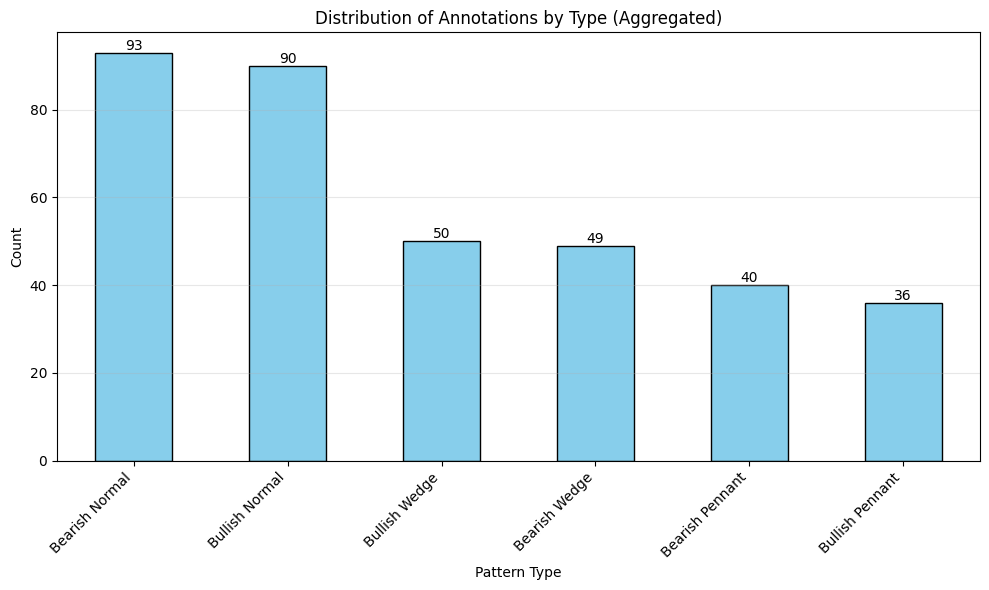

In [3]:
plt.figure(figsize=(10, 6))
ax = df_stats['Label'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Distribution of Annotations by Type (Aggregated)")
plt.xlabel("Pattern Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

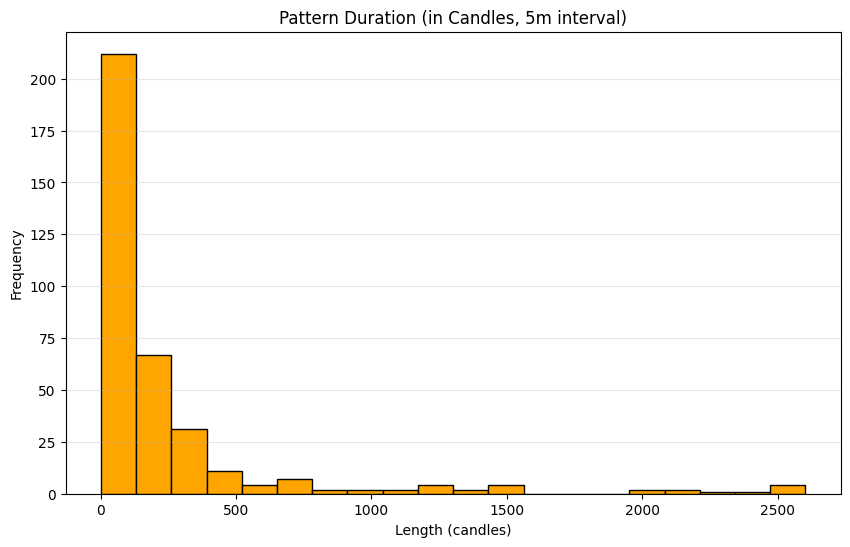

Average length: 242.6536312849162
Min: 1
Max: 2602


In [4]:
plt.figure(figsize=(10, 6))
plt.hist(df_stats['Candle_Count'], bins=20, color='orange', edgecolor='black')

plt.title("Pattern Duration (in Candles, 5m interval)")
plt.xlabel("Length (candles)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.3)
plt.show()

print("Average length:", df_stats['Candle_Count'].mean())
print("Min:", df_stats['Candle_Count'].min())
print("Max:", df_stats['Candle_Count'].max())